In [1]:

import pandas as pd
import numpy as np
import metapack as mp
from pathlib import Path
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from sdipylib.plot import  source_attribution

# /Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
# The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
#   layout[ax.rowNum, ax.colNum] = ax.get_visible()
import warnings
warnings.simplefilter("ignore")

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

%run weights.py
%run lib.py 

source = "Survey of Consumer Finances, 2016 and 2019 pooled"



In [2]:
pkg = multi_open('federalreserve.gov-consumer_finances-2016e2019-inherit', print_ref=True)
#pkg = mp.jupyter.open_source_package()
pkg

Opening:  index:federalreserve.gov-consumer_finances-2016e2019-inherit


# Survey of Consumer Finances, Inheritance Extract
`federalreserve.gov-consumer_finances-2016e2019-inherit-1.2.5` Last Update: 2020-12-11T04:21:02

_An Extract from the survey of consumer finances for studying networth and ineritance, from multiple years_


This is an extract of the 2016 and 2019 Survey of Consumer Finances, with extracted variables
and recoded variables oriented toward studying inheritance.


 
## Images

[![doc_img](docs/networth_race_inc.png "networth_race_inc")](docs/networth_race_inc.png)

Net Worth by Income Percentile and Race## Notes

* Version 1.2.2 Added the Inflatable flag
* Version 1.2.3 Inflated dollar ammounts to current dollars
## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [inherit_scf_16_19](data/inherit_scf_16_19.csv)**. Extract of the 2016 and 2019 SCF for inheritance and networth

## References
<ul><li> <strong>scf</string>, <em>metapack+http://library.metatab.org/federalreserve.gov-consumer_finances.csv</em>. Survey of consumer finances data packages</li><li> <strong><a href="https://fred.stlouisfed.org/graph/fredgraph.csv?&id=CPIAUCSL">cpi</a></strong>. Consumer Price Index</li><ul>

In [3]:
inherit_scf_16_19 = pkg.resource('inherit_scf_16_19').dataframe()

df =   make_descriptive_df(inherit_scf_16_19)    
dfs = df.sample(500_000, replace=True, weights=df.wt0)

In [4]:
dfs90 = dfs[dfs.nincpctle < 90]

The first, and most central fact of our analysis is that there is a very large difference between the networth of white and black households[<sup>1</sup>](#fn1). A related fact is there are many ways to measure the difference, and even more ways to adjust the data, with the result that the racial inequality of household wealth is not a single number, but a range of numbers, each of which serves a different interpretation. It is our goal with this post to describe therange of assumptions and adjustments so people engaged in studying inequality will have a more accurate understanding of the issue. 

The most basic summary statistics for most types of data is the mean, or average. The mean networth of US black households for our dataset is $\$$152,000, while the white household average networth is over $\$$1M. However, using the mean can be misleading for data that are related to money, so the median -- the value at which 50% of households have a higher networth, and 50\$\%\$ have a lower networth, is often the preferred choice. The median networth of black households is about  $\$$20,000, while the white median networth is about $\$$190,000. Both median values are about 20% of the mean values, a very large difference. So, which value is correct?

<span id="fn1">(1)</span> Note that what we call a "household" isn't actually a household. As defined by the US Census, a household is a geoup of people who live in singe dwelling, and may consist of exgtended families or multiple famliles. In the Survey of Consumer Finances, what is called a household is actually a "Primary Exconomic Unit", which the sruvey defines as: 

    In brief, the PEU consists of an economically dominant single individual or couple (married or living as partners in a household and all other individuals in the household who are financially interdependent with that individual or couple.  For example, in the case of a household composed of a married couple who own their home, a minor child, a dependent adult child, and a financially independent parent of one of the members of the couple, the PEU would be the couple and the two children.
    
The practical implication of this definition of a household is that we will be able to assume that the househodls have one or two adults who control the household's finances, which will be imporant later when we example wealth on a per-person basis, adjusting for household size. 
    

In [5]:
dfs.groupby(['race']).hhsize.mean()

race
black    1.347387
white    1.601958
Name: hhsize, dtype: float64

In [6]:
a = dfs.groupby('race').networth.median().to_frame('median')
c = dfs.groupby('race').networth.mean().to_frame('mean')
t = a.join(c)
display(t)
(t.loc['white']/t.loc['black']).to_frame('ratio').round(2)\
    .join((t.loc['white']-t.loc['black']).to_frame('difference').round(-3).astype(int))


,median,mean
race,,
black,20411.716862,1.574407e+05
white,191949.032267,1.026683e+06


,ratio,difference
median,9.40,172000
mean,6.52,869000


6.521077047027904


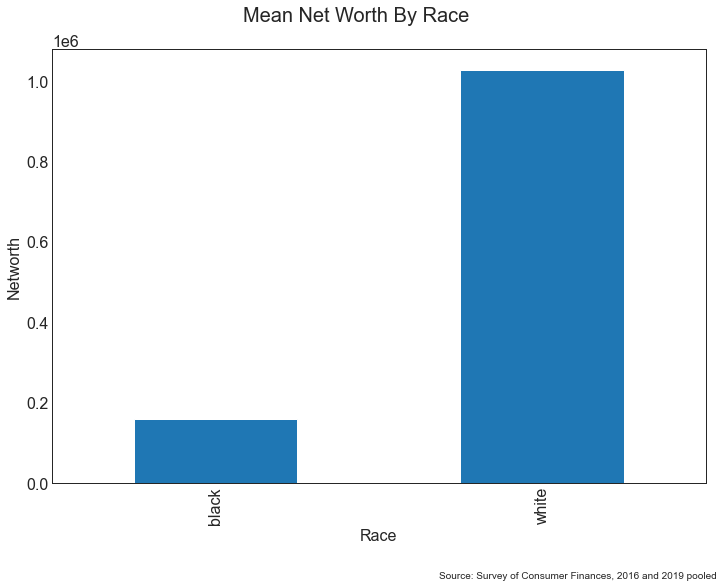

In [7]:
t = dfs.groupby('race').networth.mean()
print(t.white/t.black)
    
with new_plot('Mean Net Worth By Race', source,
             xlabel='Race', ylabel='Networth') as (fig,ax):
    
    t.plot.bar(ax=ax)

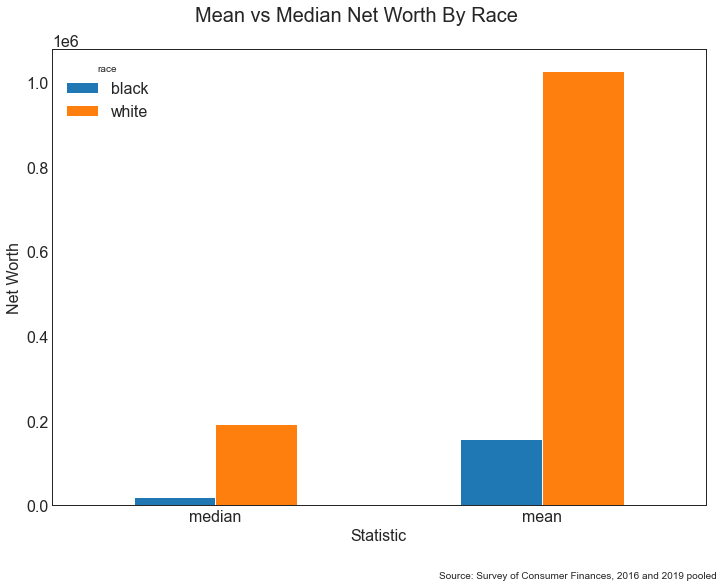

In [8]:

with new_plot('Mean vs Median Net Worth By Race', source,
             xlabel='Statistic', ylabel='Net Worth') as (fig,ax):
    a = dfs.groupby('race').networth.median().to_frame('median')
    #b = dfs90.groupby('race').networth.mean().to_frame('mean<90%')
    c = dfs.groupby('race').networth.mean().to_frame('mean')
    
    t = a.join(c)
    
    t.T.plot.bar(ax=ax)
    plt.xticks(rotation=0) 

    

If you want to show a large ratio you use the median, and if you want to show a large difference, you use the mean. 

However, when there are a small number of records in a group, the median have be very noisy, where the mean is more stable. 


year
2016    6.322308
2019    6.736372
Name: networth, dtype: float64


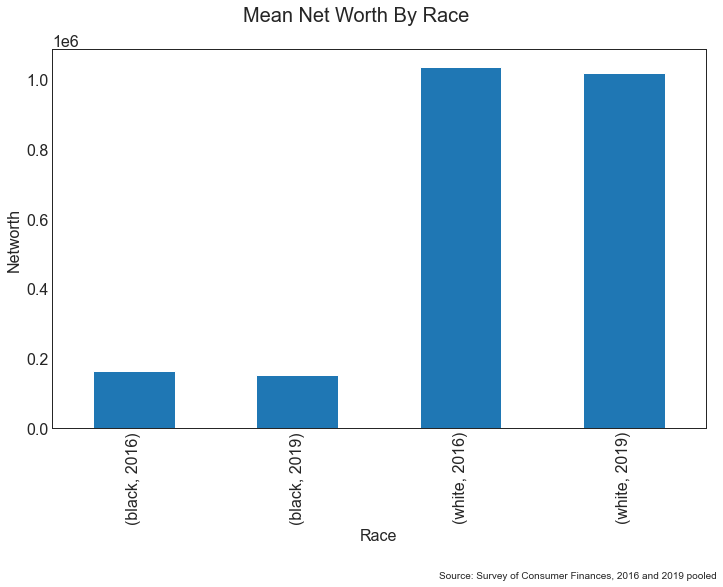

In [9]:
t = dfs.groupby(['race','year']).networth.mean()
print(t.white/t.black)
    
with new_plot('Mean Net Worth By Race', source,
             xlabel='Race', ylabel='Networth') as (fig,ax):
    
    t.plot.bar(ax=ax)

In [10]:
a = dfs.groupby('race').networth.median().to_frame('median')
c = dfs.groupby('race').networth.mean().to_frame('mean')
t = a.join(c)
(t.loc['white']/t.loc['black']).to_frame('ratio').round(2)\
    .join((t.loc['white']-t.loc['black']).to_frame('difference').round(-3).astype(int))

,ratio,difference
median,9.40,172000
mean,6.52,869000


In [11]:
a = dfs.groupby('race').networth.median().to_frame('median')
c = dfs.groupby('race').networth.mean().to_frame('mean')
t = a.join(c)
(t.loc['white']/t.loc['black']).to_frame('ratio').round(2)\
    .join((t.loc['white']-t.loc['black']).to_frame('difference').round(-3).astype(int))

,ratio,difference
median,9.40,172000
mean,6.52,869000


The reason for the difference between the median and the mean is that income is strongly skewed to the higher end. The top 1% earns a lot more money then the lower groups. 

In [12]:
a = dfs.groupby('race').networthpc.median().to_frame('median')
c = dfs.groupby('race').networthpc.mean().to_frame('mean')
t = a.join(c)
display(t)
(t.loc['white']/t.loc['black']).to_frame('ratio').round(2)\
    .join((t.loc['white']-t.loc['black']).to_frame('difference').round(-3).astype(int))

,median,mean
race,,
black,16256.16691,111162.885012
white,120322.54932,600385.450768


,ratio,difference
median,7.4,104000
mean,5.4,489000


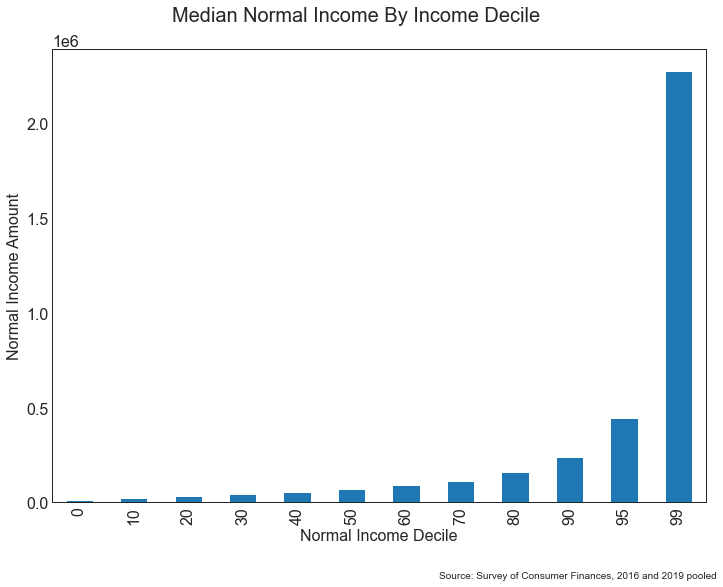

In [13]:

with new_plot('Median Normal Income By Income Decile', source,
             xlabel='Normal Income Decile', ylabel='Normal Income Amount') as (fig,ax):
    dfs.groupby('nincpctle').norminc.mean().plot.bar(ax=ax);


In [14]:
dfs.hhsize.sum(), len(dfs)

(777128, 500000)

In [15]:
a = dfs[dfs.nincpctle>=90].networth.sum()
b = dfs[dfs.nincpctle<90].networth.sum()
a/(a+b)


0.6523931545253449

In [16]:
a = dfs[dfs.nincpctle>=99].networth.sum()
b = dfs[dfs.nincpctle<99].networth.sum()
a/(a+b)

0.3011745463158841

Wealth inequality is primarily non-racial; the top earners have a disproportionate share of the income and the wealth.

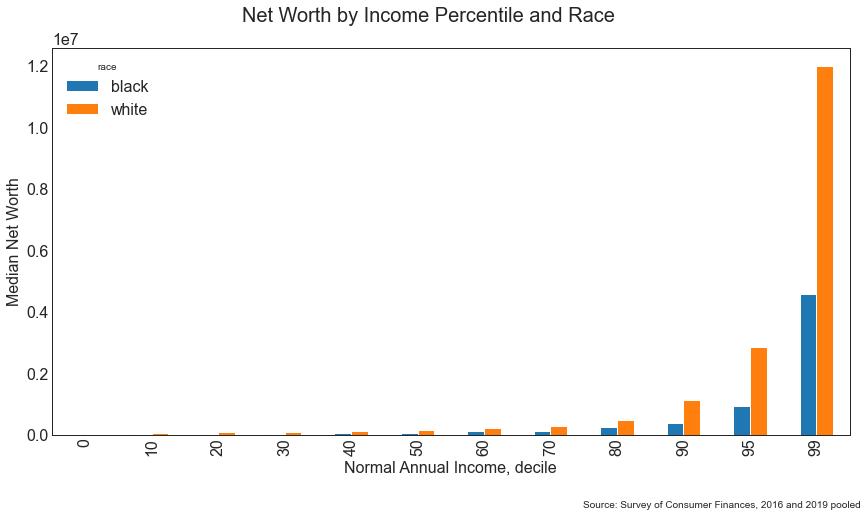

In [17]:
with new_plot('Net Worth by Income Percentile and Race', source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Median Net Worth') as (fig,ax):
    t = dfs.groupby(['nincpctle', 'race']).networth.median().unstack()
    t.plot.bar(ax=ax)


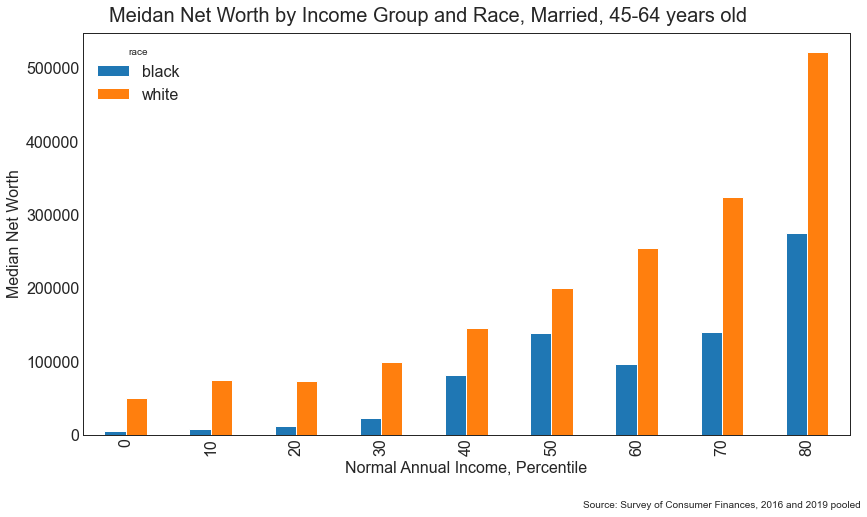

In [18]:
with new_plot('Meidan Net Worth by Income Group and Race, Married, 45-64 years old', 
              source, figsize=(12,7),
             xlabel='Normal Annual Income, Percentile', ylabel='Median Net Worth') as (fig,ax):
    t = dfs90
    t = t[(t.hhsize == 2) & (t.agecl.isin(['45-54','55-64']))  ]

    t.groupby(['nincpctle', 'race']).networth.median().unstack().plot.bar(ax=ax)

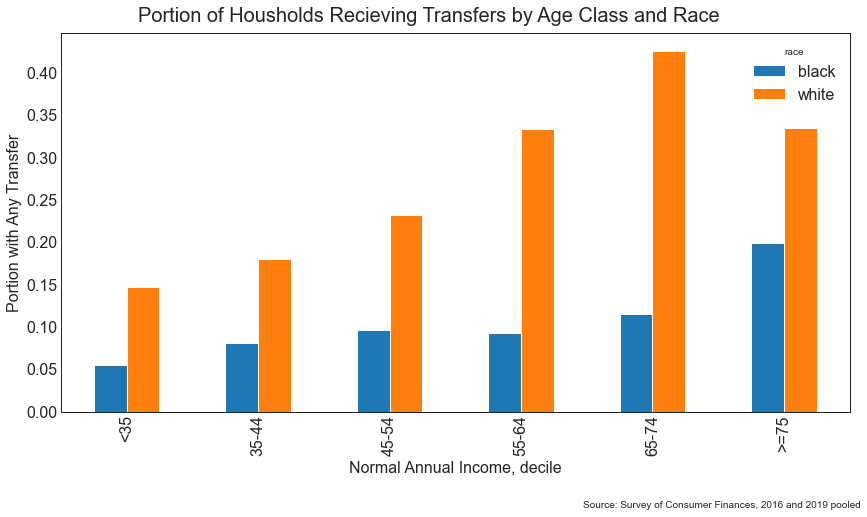

In [19]:
with new_plot('Portion of Housholds Recieving Transfers by Age Class and Race',
              source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Portion with Any Transfer') as (fig,ax):
    
    t = dfs.groupby(['agecl','race']).any_transfer.mean().unstack().plot.bar(ax=ax)


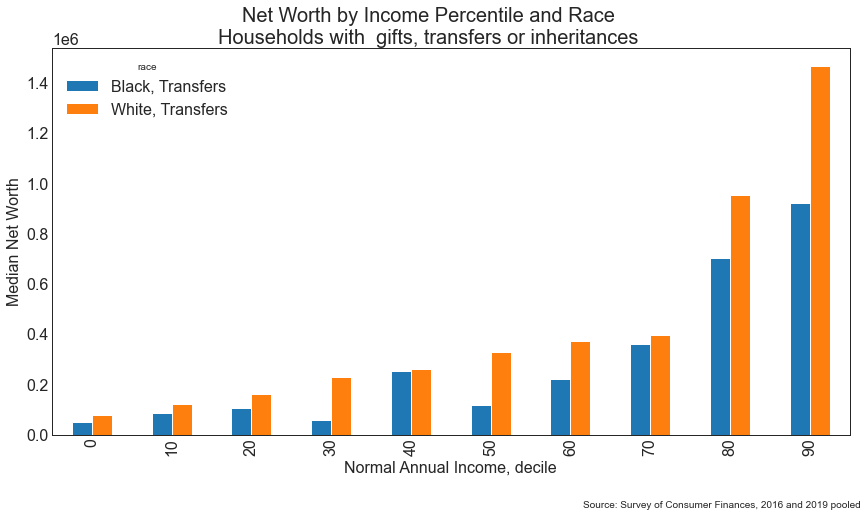

In [20]:
with new_plot('Net Worth by Income Percentile and Race\nHouseholds with  gifts, transfers or inheritances',
              source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Median Net Worth') as (fig,ax):
    
    nh = dfs[dfs.gi_sum == 0]  # "no help"
    yh = dfs[dfs.gi_sum != 0] # " Yes help"
    
    t = yh[yh.nincpctle<95].groupby(['nincpctle','race']).networth.median().unstack()

    t.rename(columns={'white':'White, Transfers', 'black':'Black, Transfers'}).plot.bar(ax=ax)
    


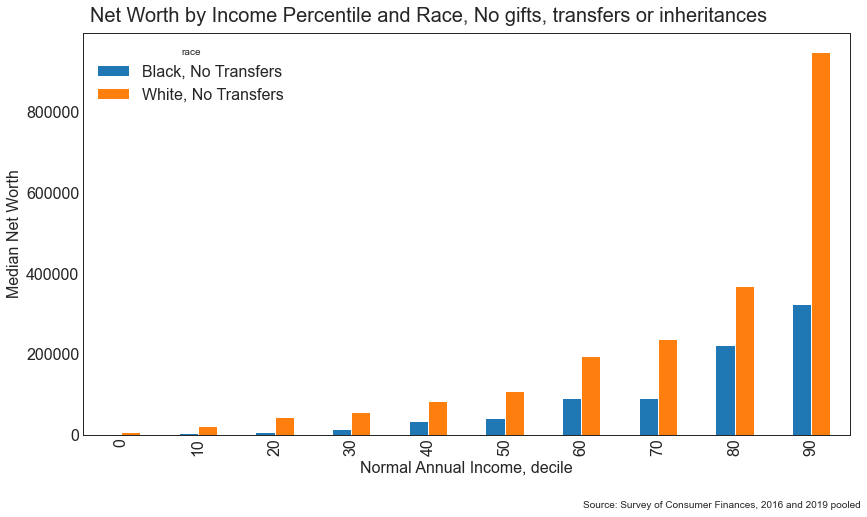

In [21]:
with new_plot('Net Worth by Income Percentile and Race, No gifts, transfers or inheritances',
              source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Median Net Worth') as (fig,ax):
    
    nh = dfs[dfs.gi_sum == 0]  # "no help"
    yh = dfs[dfs.gi_sum != 0] # " Yes help"
    
    t = nh[nh.nincpctle<95].groupby(['nincpctle','race']).networth.median().unstack()

    t.rename(columns={'white':'White, No Transfers', 'black':'Black, No Transfers'}).plot.bar(ax=ax)
    

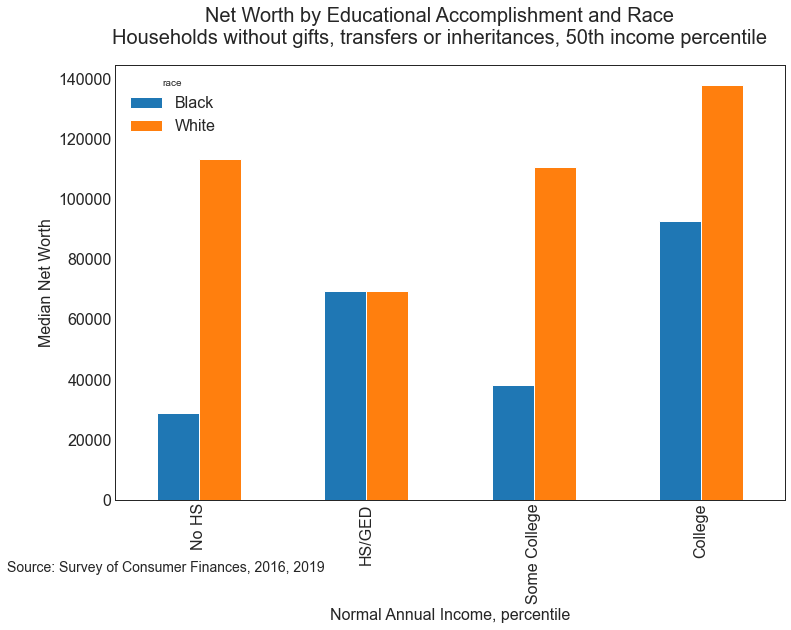

In [22]:
fig, ax = plt.subplots(figsize=(12,8))

fig.suptitle('Net Worth by Educational Accomplishment and Race\nHouseholds without '
             'gifts, transfers or inheritances, 50th income percentile', fontsize=20)
t = dfs90[ (dfs90.nincpctle == 60) & (dfs90.gi_sum == 0) ]
t = t.groupby(['edcl','race']).networthpc.median().unstack()

t.rename(columns={'white':'White', 'black':'Black'}).plot.bar(ax=ax)
plt.gcf().text(0,0, f"Source: Survey of Consumer Finances, 2016, 2019", fontsize=14) 
ax.set_xlabel('Normal Annual Income, percentile')
ax.set_ylabel('Median Net Worth');


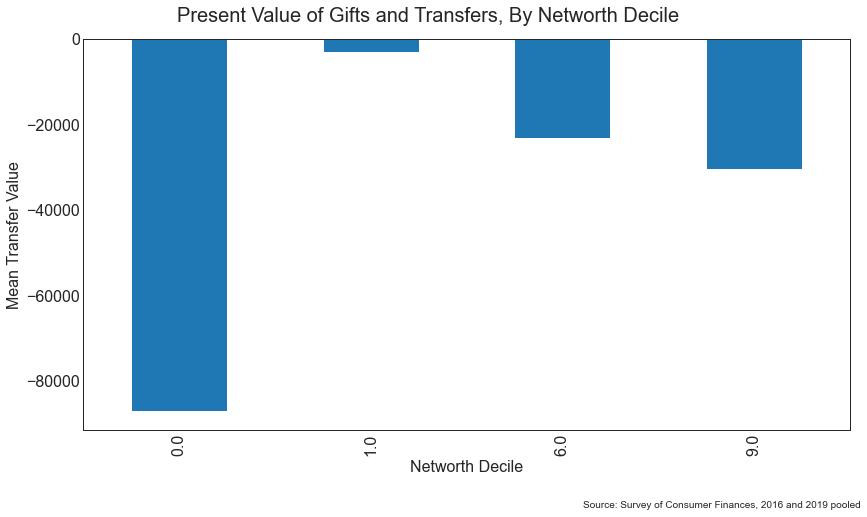

In [23]:

with new_plot('Present Value of Gifts and Transfers, By Networth Decile', source, figsize=(12,7),
             xlabel='Networth Decile', ylabel='Mean Transfer Value') as (fig,ax):
    t = dfs[(dfs.hhsize == 2) & 
            (dfs.agecl.isin(['45-54','55-64'])) &
            (dfs.edcl=='College') &
            (dfs.nincpctle<95) & 
            (dfs.nwpctlecat<10)]
    #t.groupby('nwpctle').gi_value_cd.mean().plot.bar(ax=ax)
    t.groupby('gi_value_cd_decile').networth.mean().plot.bar(ax=ax)


,networth_pctle,gi_value_cd_pctle
networth_pctle,1.0000,0.3698
gi_value_cd_pctle,0.3698,1.0000


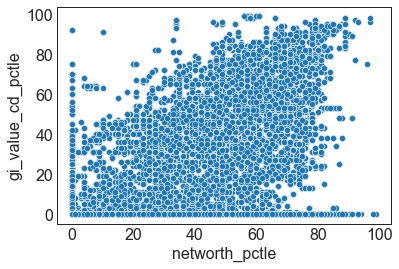

In [24]:
sns.scatterplot(data=dfs90, x='networth_pctle', y='gi_value_cd_pctle');

t=dfs[['networth_pctle','gi_value_cd_pctle']].dropna()
t.corr()

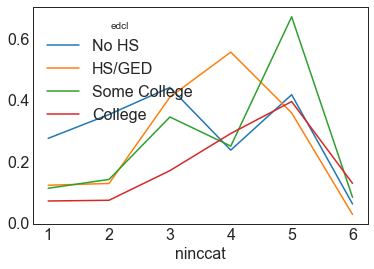

In [25]:
t = df.groupby(['ninccat','edcl','race']).networth.median().unstack()
t = t.black/t.white
t.unstack().plot()

# Role of Stocks and Home Equity

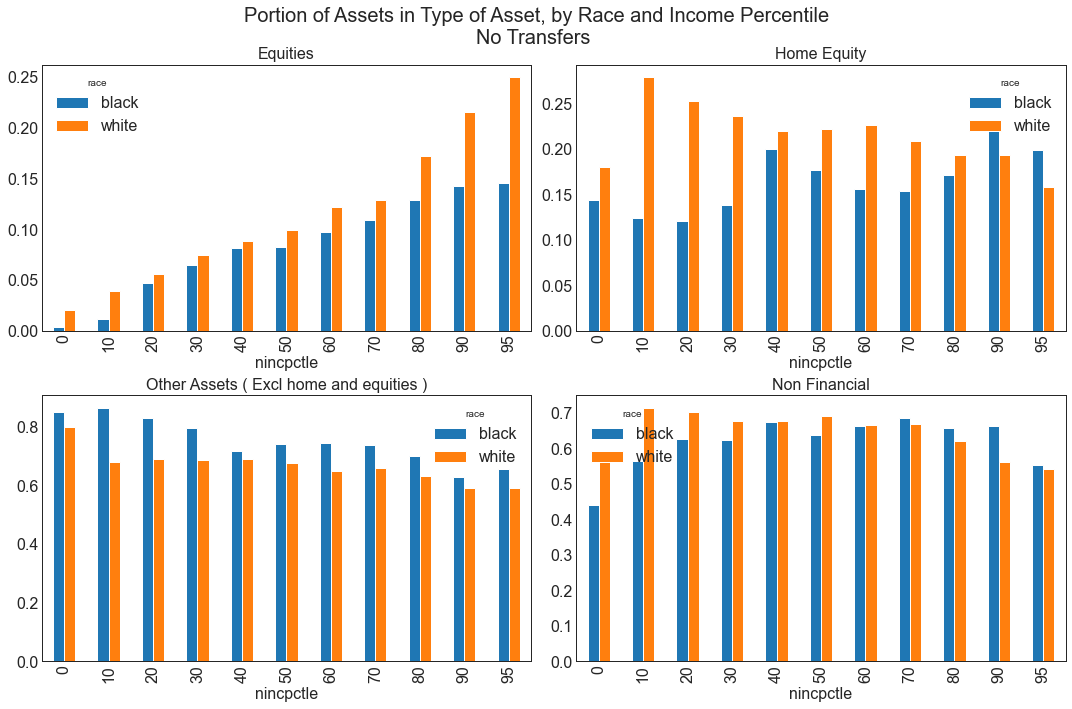

In [26]:
t = dfs[dfs.n_transfer==0].copy()
t['house_r'] = t.homeeq/t.asset
t['eq_r'] = t.equity/t.asset
t['other_r'] = (t.asset-t.equity-t.homeeq)/t.asset
t['nfin_r'] = t.nfin/t.asset
t[['asset','networth','house_r', 'eq_r','other_r', 'nfin_r']].corr()

fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = list(ax.flat)

g = t[t.nincpctle<99].groupby(['race','nincpctle'])

g.eq_r.mean().unstack().T.plot.bar(ax=ax[0]); ax[0].set_title('Equities', fontsize=16)
g.house_r.mean().unstack().T.plot.bar(ax=ax[1]); ax[1].set_title('Home Equity', fontsize=16)
g.other_r.mean().unstack().T.plot.bar(ax=ax[2]); ax[2].set_title('Other Assets ( Excl home and equities )', fontsize=16)
g.nfin_r.mean().unstack().T.plot.bar(ax=ax[3]); ax[3].set_title('Non Financial', fontsize=16)
fig.suptitle("Portion of Assets in Type of Asset, by Race and Income Percentile\nNo Transfers ", fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.90)

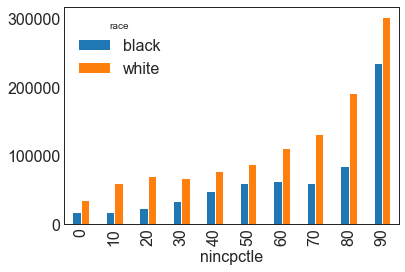

In [27]:
t = nh.copy()
t['he_nfin_r'] = (t.homeeq+t.equity)/ (t.homeeq+t.equity+t.nfin)
g = t[t.nincpctle<95].groupby(['race','nincpctle'])
g.homeeq.mean().unstack().T.plot.bar()

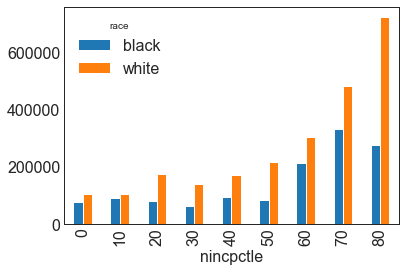

In [28]:
t = nh.copy()
t = t[ (t.nincpctle < 90) & (t.homeeq > 0) & (t.gi_sum == 0) & (t.married==2)]
g = t[t.nincpctle<95].groupby(['race','nincpctle'])
t = g.networth.median().unstack().T
t.plot.bar()

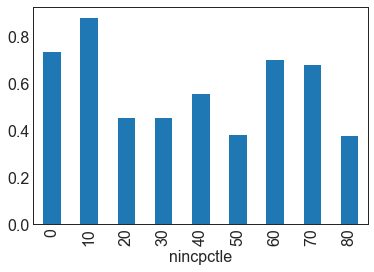

In [29]:
(t.black/t.white).plot.bar()

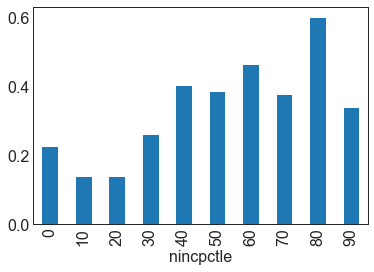

In [30]:
t = nh.copy()
#t = t[ (t.nincpctle < 90) & (t.homeeq > 0) & (t.gi_sum == 0) & (t.married==2)]
g = t[t.nincpctle<95].groupby(['race','nincpctle'])
t = g.networth.median().unstack().T

(t.black/t.white).plot.bar()

In [31]:
t = dfs[dfs.age_1 <45].groupby(['nincpctle','race']).any_transfer.mean().unstack() 
t

race,black,white
nincpctle,,
0,0.021783,0.116638
10,0.054278,0.180920
20,0.032227,0.138304
30,0.069401,0.122837
40,0.136569,0.148177
50,0.118490,0.160002
60,0.037146,0.189328
70,0.082955,0.187158
80,0.018841,0.147575


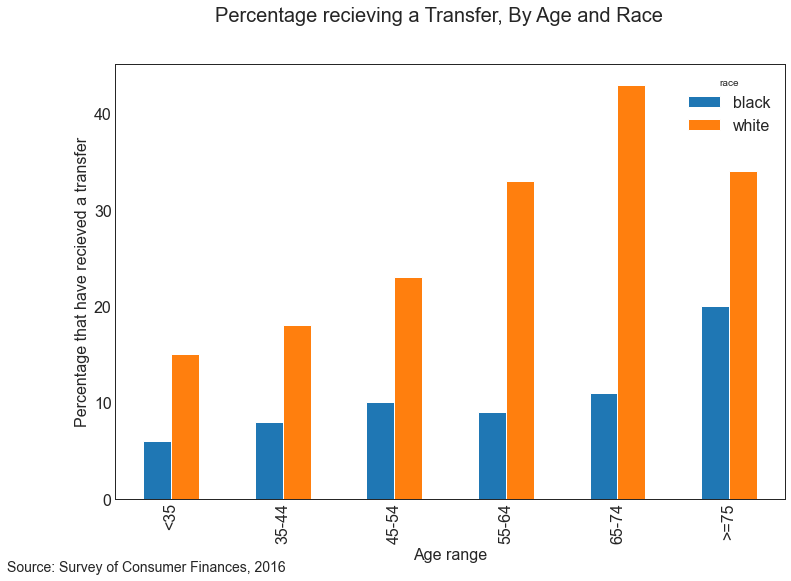

In [32]:
fig, ax = plt.subplots(figsize=(12,8))

fig.suptitle('Percentage recieving a Transfer, By Age and Race', fontsize=20)

t = (dfs.groupby(['race', 'agecl']).any_transfer.mean()*100).round(0).unstack().T

t.plot.bar(ax=ax)
plt.gcf().text(0,0, f"Source: Survey of Consumer Finances, 2016", fontsize=14) 
ax.set_xlabel('Age range')
ax.set_ylabel('Percentage that have recieved a transfer');



In [68]:
t = dfs[(dfs.networth > 0) & (dfs.networth_pctle < 90) & (dfs.n_transfer > 0)]
s =(t.gi_value_cd/t.networth).replace(np.inf,np.nan)
s.groupby(t.race).describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
black,8369.0,1.039393,1.630381,0.001568,0.243346,0.530619,1.099984,11.800097
white,106991.0,6.089238,221.308822,-0.000004,0.081837,0.249823,0.718719,11139.291354


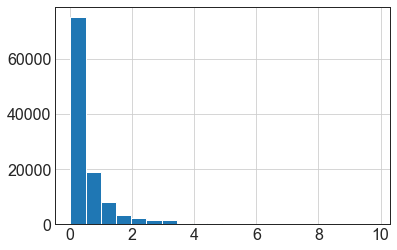

In [70]:
(s[(s > 0) & (s<10)]).hist(bins=20)